# Calculate Nematic Order Parameter

In [1]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.collections as clt
import pandas as pd
import string as st
import scipy.spatial as spp
import scipy.optimize as spo
import sympy as smp
import copy as cp
import pickle
import os
import sys

from IPython.display import HTML, clear_output

smp.init_printing()
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Load a file and extract dimers.

In [3]:
dirc = "Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_0/"
files = os.scandir(dirc)
base_names = [os.path.splitext(file.name)[0] for file in files if file.name.endswith(".lammpstrj")]

In [4]:
field = 6
file = os.path.join(dirc,'field_%u'%field)
file

'Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_0/field_6'

In [5]:
sim = pickle.load(open( file+".p", "rb" ))

In [6]:
%%time
trj = lmp.trj_lazyread(file+".lammpstrj")
trj = trj[0::100]
dim = lmp.dimers(trj, sim, distance=3)
dim = lmp.dimers_findpositions(dim,trj,sim)

Wall time: 47.3 s


Dimers Animation

In [7]:
anim = lmp.animate_dim(dim,sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

# Calculate the Nematic Order Parameter

The nematic order parameter is given by:

$$S\equiv\left<\frac{3\cos^2\left(\theta\right)-1}{2}\right>$$

where $\theta$ is the angle between a director vector $\hat{n}$ and the dimer vector $\vec{s}$

To obtain the director my first approach is to plot the histogram of the positions. The histogram shows certain directional preference, especially at $\pm90^º$ and for around $160^º$.

However this would mean that we have two directors

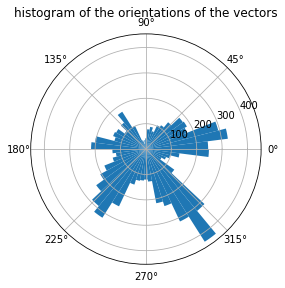

In [8]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

direction = np.array(list(dim.direction.values))
theta = np.arctan2(direction[:,1],direction[:,0])

ax.hist(theta,50);
ax.set_title("histogram of the orientations of the vectors")

Another approach is to calculate the order parameter for several different directors and try to obtain the largest. 

In the following cell, we map the $360º$ in $1º$ steps and we plot the nematic order parameter that we obtain. We can see that the director vector must have an angle of $120º$ 

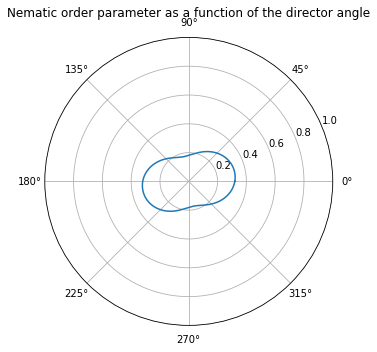

In [9]:
theta_0 = np.linspace(0,2*np.pi,360)

S = [lmp.nematic_order(dim,[np.cos(th),np.sin(th)]) for th in theta_0]

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

ax.plot(theta_0,S);
ax.set_rmax(1)
ax.set_title("Nematic order parameter as a function of the director angle");

We programed the function `lmp.nematic_order()` so that if we call it without the director field argument, the function calculates it by maping the space and returning the value with the largest nematic order. 

In [10]:
help(lmp.nematic_order)

Help on function nematic_order in module lammps2d.support:

nematic_order(dim, director=False)
    Calculates the nematic order parameter $S = <1/2*(3cos(theta)^2-1)>$, where $theta$ is the angle between the director vector and the dimers. If the director is not given, the function returns the order parameter and the director with the largest order with a resolution of one degree.



In [11]:
[S,director] = lmp.nematic_order(dim)
S

Now we can calculate the director for all the simulations to try to extract a dependence on the field

In [12]:
def calculate_order_from_file_single_frame(file):
    clear_output(wait=True)
    print("processing ", file)
    sim = pickle.load(open( file+".p", "rb" ))
    trj = lmp.trj_lazyread(file+".lammpstrj")[0::100]
    dim = lmp.dimers(trj, sim, distance=3)
    dim = lmp.dimers_findpositions(dim,trj,sim)
    [S,director] = lmp.nematic_order(dim)
    return S, sim.field_parameters.magnitude

S,f = zip(*[calculate_order_from_file_single_frame(os.path.join(dirc,b)) for b in base_names])

processing  Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_0/field_18


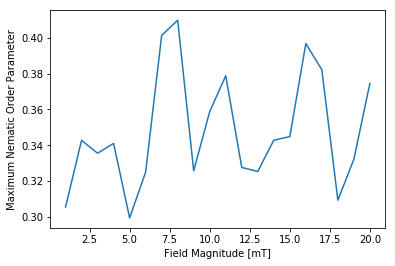

In [13]:
Order = pd.DataFrame(index=np.array(f),data={"NematicOrder":np.array(S)})
Order.index.name="field"
Order = Order.sort_index()
Order.to_csv("OrderParameters.dat",sep="\t")

plt.plot(Order.index,Order.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

We saved this order parameter as a  `.dat` because the calculation routine takes a while. 

And we can now read it at a later time

In [14]:
Order = pd.read_csv("OrderParameters.dat",sep='\t',index_col='field')

## Some examples from the graph

The dataset of Order Parameter vs Field looks very noisy. However, we can try looking at specific points to see if we understand the variations in ordering.

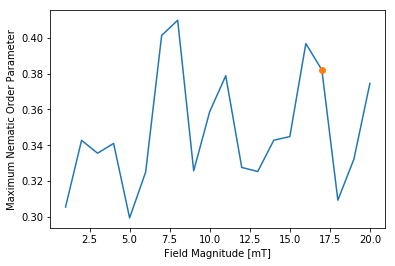

In [16]:
plt.plot(Order.index,Order.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

field = 17
plt.plot(field,Order[Order.index==field].NematicOrder,'o')

file = os.path.join(dirc,"field_%u"%field)
sim = pickle.load(open(file+".p", "rb" ))
trj = lmp.trj_lazyread(file+".lammpstrj")[0::100]
dim = lmp.dimers(trj, sim, distance=3)
dim = lmp.dimers_findpositions(dim,trj,sim)

anim = lmp.animate_dim(dim,sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

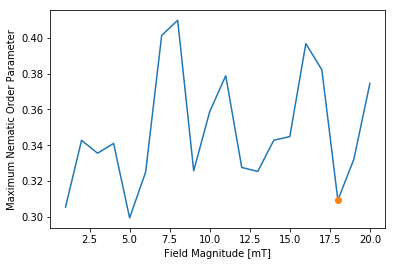

In [17]:
plt.plot(Order.index,Order.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

field = 18
plt.plot(field,Order[Order.index==field].NematicOrder,'o')

file = os.path.join(dirc,"field_%u"%field)
sim = pickle.load(open(file+".p", "rb" ))
trj = lmp.trj_lazyread(file+".lammpstrj")[0::100]
dim = lmp.dimers(trj, sim, distance=3)
dim = lmp.dimers_findpositions(dim,trj,sim)

anim = lmp.animate_dim(dim,sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

This difference in order parameter seems to represent no large qualitative changes. 

# Nematic Order of a Single Frame

It doesn't make much sense to obtain the nematic order parameter of the whole trajectories. Instead I should obtain it for the last frame, and then rely on several experiments for statistics. 

From looking at these videos, it appears that the high nematic order points at low field might come from the fact that the low field allows some relaxation of the ordering, while at higher fields the ordering is frozen. 

In [18]:
def calculate_order_from_file_single_frame(file):
    clear_output(wait=True)
    print("processing ", file)
    sim = pickle.load(open( file+".p", "rb" ))
    trj = lmp.trj_lazyread(file+".lammpstrj")[-1]
    dim = lmp.dimers(trj, sim, distance=3)
    dim = lmp.dimers_findpositions(dim,trj,sim)
    [S,director] = lmp.nematic_order(dim)
    return S, sim.field_parameters.magnitude

S,f = zip(*[calculate_order_from_file_single_frame(os.path.join(dirc,b)) for b in base_names])

processing  Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_0/field_18


In [19]:
Order = pd.DataFrame(index=np.array(f),data={"NematicOrder":np.array(S)})
Order.index.name="field"
Order.to_csv("OrderParameters_singleframe.dat",sep="\t")

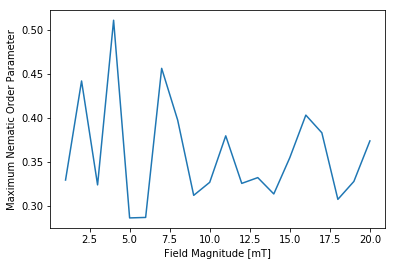

In [20]:
Order = Order.sort_index()

plt.plot(Order.index,Order.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

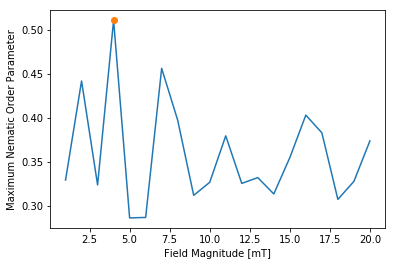

In [21]:
plt.plot(Order.index,Order.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

field = 4
plt.plot(field,Order[Order.index==field].NematicOrder,'o')

file = os.path.join(dirc,"field_%u"%field)
sim = pickle.load(open(file+".p", "rb" ))
trj = lmp.trj_lazyread(file+".lammpstrj")[0::100]
dim = lmp.dimers(trj, sim, distance=3)
dim = lmp.dimers_findpositions(dim,trj,sim)

anim = lmp.animate_dim(dim,sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

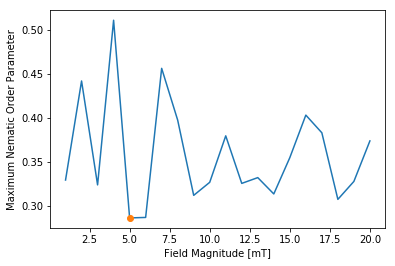

In [22]:
plt.plot(Order.index,Order.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

field = 5
plt.plot(field,Order[Order.index==field].NematicOrder,'o')

file = os.path.join(dirc,"field_%u"%field)
sim = pickle.load(open(file+".p", "rb" ))
trj = lmp.trj_lazyread(file+".lammpstrj")[0::100]
dim = lmp.dimers(trj, sim, distance=3)
dim = lmp.dimers_findpositions(dim,trj,sim)

anim = lmp.animate_dim(dim,sim,start=0,end=120,step=1,speedup=15)
HTML(anim.to_html5_video())

# Nematic order from several runs

### From Random starting conditions

In [24]:
dirc = 'Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/'

In [25]:
def calculate_order_from_file_single_frame(file):
    clear_output(wait=True)
    print("processing ", file)
    sim = pickle.load(open( file+".p", "rb" ))
    trj = lmp.trj_lazyread(file+".lammpstrj")[-1]
    dim = lmp.dimers(trj, sim, distance=3)
    dim = lmp.dimers_findpositions(dim,trj,sim)
    [S,director] = lmp.nematic_order(dim)
    return S, sim.field_parameters.magnitude

In [29]:
S,f = zip(*[calculate_order_from_file_single_frame(os.path.join(root,os.path.splitext(file)[0])) 
            for root, dirs, files in os.walk(dirc) 
            for file in files 
            if file.endswith(".p")])

processing  Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_1/exp_9\field_20


In [30]:
Order = pd.DataFrame(index=np.array(f),data={"NematicOrder":np.array(S)})
Order.index.name="field"
Order.to_csv("OrderParameters_singleframe_Statistics_random.dat",sep="\t")

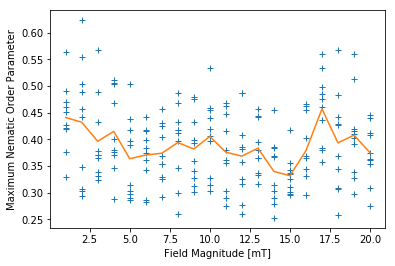

In [31]:
MeanOrder = Order.groupby('field').mean()

plt.plot(Order.index,Order.NematicOrder,'+')
plt.plot(MeanOrder.index,MeanOrder.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

### Starting from a square lattice

In [ ]:
dirc = 'Z:/SimulationsOfDimerSystem/NematicPhase/DobnikarConditions_T300K/random_0/'

S,f = zip(*[calculate_order_from_file_single_frame(os.path.join(root,os.path.splitext(file)[0])) 
            for root, dirs, files in os.walk(dirc) 
            for file in files 
            if file.endswith(".p")])

Order = pd.DataFrame(index=np.array(f),data={"NematicOrder":np.array(S)})
Order.index.name="field"
Order.to_csv("OrderParameters_singleframe_Statistics_random.dat",sep="\t")

In [43]:
OrderNr = pd.read_csv("OrderParameters_singleframe_Statistics_not_random.dat",sep="\t",index_col="field")

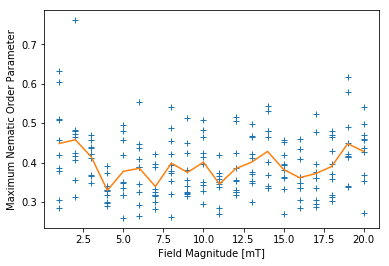

In [45]:
MeanOrderNr = OrderNr.groupby('field').mean()

plt.plot(OrderNr.index,OrderNr.NematicOrder,'+')
plt.plot(MeanOrderNr.index,MeanOrderNr.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

# Comparison

In [51]:
MeanOrder = Order.groupby('field').mean()
StdErrOrder = Order.groupby('field').std()/np.sqrt(Order.groupby('field').count())

MeanOrderNr = OrderNr.groupby('field').mean()
StdErrOrderNr = OrderNr.groupby('field').std()/np.sqrt(Order.groupby('field').count())

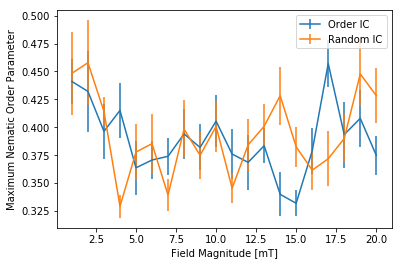

In [53]:
plt.errorbar(MeanOrder.index,MeanOrder.NematicOrder,StdErrOrder.NematicOrder)
plt.errorbar(MeanOrderNr.index,MeanOrderNr.NematicOrder,StdErrOrderNr.NematicOrder)
plt.xlabel("Field Magnitude [mT]")
plt.ylabel("Maximum Nematic Order Parameter")

plt.legend({"Random IC", "Order IC"})